In [152]:
from functools import reduce
import pdb

import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PDB_small
from MDAnalysis.analysis import distances
from MDAnalysis.analysis import contacts

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def calculate_bin(u):
    
    # Selections
    sel_Pro1 = "resid 227"
    sel_Phe2 = "resid 228"
    sel_Lys32 = "resid 335"
    sel_Arg36 = "resid 262"
    sel_Ser50 = "resid 163"
    sel_Ile64 = "resid 333"
    sel_Leu96 = "resid 209"
    sel_Ile107 = "resid 208"
    sel_lig = "resname NON1"

    # Selections in MD analysis format
    Pro1 = u.select_atoms(sel_Pro1)
    Phe2 = u.select_atoms(sel_Phe2)
    Lys32 = u.select_atoms(sel_Lys32)
    Arg36 = u.select_atoms(sel_Arg36)
    Ser50 = u.select_atoms(sel_Ser50)
    Ile64 = u.select_atoms(sel_Ile64)
    Leu96 = u.select_atoms(sel_Leu96)
    Ile107 = u.select_atoms(sel_Ile107)
    lig = u.select_atoms(sel_lig)

    def contacts_within_cutoff(u, group_a, group_b, radius=4.5):
        timeseries = []
        for ts in u.trajectory:
            # calculate distances between group_a and group_b
            dist = contacts.distance_array(group_a.positions, group_b.positions)
            # determine which distances <= radius
            n_contacts = contacts.contact_matrix(dist, radius).sum()
            timeseries.append(n_contacts)
        return np.array(timeseries)
    
    # Create DataFrame just with the frame number
    frames = []
    for ts in u.trajectory:
        frames.append(ts.frame)

    df = pd.DataFrame(frames, columns=["Frame"])
    
    contact_Pro1 = contacts_within_cutoff(u, lig, Pro1, radius=2.5)
    contact_Phe2 = contacts_within_cutoff(u, lig, Phe2, radius=2.5)
    contact_Lys32 = contacts_within_cutoff(u, lig, Lys32, radius=2.5)
    contact_Arg36 = contacts_within_cutoff(u, lig, Arg36, radius=2.5)
    contact_Ser50 = contacts_within_cutoff(u, lig, Ser50, radius=2.5)
    contact_Ile64 = contacts_within_cutoff(u, lig, Ile64, radius=2.5)
    contact_Leu96 = contacts_within_cutoff(u, lig, Leu96, radius=2.5)
    contact_Ile107 = contacts_within_cutoff(u, lig, Ile107, radius=2.5)

    contact_Pro1 = np.where(contact_Pro1 == 0, 0, 1)
    contact_Phe2 = np.where(contact_Phe2 == 0, 0, 1)
    contact_Lys32 = np.where(contact_Lys32 == 0, 0, 1)
    contact_Arg36 = np.where(contact_Arg36 == 0, 0, 1)
    contact_Ser50 = np.where(contact_Ser50 == 0, 0, 1)
    contact_Ile64 = np.where(contact_Ile64 == 0, 0, 1)
    contact_Leu96 = np.where(contact_Leu96 == 0, 0, 1)
    contact_Ile107 = np.where(contact_Ile107 == 0, 0, 1)

    # Assign columns to DataFrame
    df_bin = df.assign(Pro1 = contact_Pro1,
                        Phe2 = contact_Phe2,
                        Lys32 = contact_Lys32,
                        Arg36 = contact_Arg36,
                        Ser50 = contact_Ser50,
                        Ile64 = contact_Ile64,
                        Leu96 = contact_Leu96,
                        Ile107 = contact_Ile107
                        )

    return df_bin
        

In [159]:
def calculate_CF_WCF(df_bin,compound_name):
    # Enviromental variable
    column_names = df_bin.columns.values.tolist()

    column_names.pop(0)
    frames = df_bin["Frame"].values.tolist()

    CF = []
    for name in column_names:
        CF_raw = df_bin[name].value_counts()[1] / len(df_bin.index)
        CF.append(round(CF_raw, 2))

    CF_zip = list(zip(column_names, CF))

    # Calculate CF
    df_CF = pd.DataFrame(CF_zip, columns=["Residue","CF_" + compound_name])

    # Calculate WCF
    df_WCF = pd.DataFrame(frames,columns=["Frame"])

    for name, CF in CF_zip:
        df_WCF[name + "_CF"] = df_bin[name] * CF
    
    df_WCF.set_index("Frame",inplace=True)
    df_WCF["WCF"] = df_WCF.sum(axis=1)
    df_WCF.sort_values("WCF",ascending=False,inplace=True)
    
    return df_CF, df_WCF


In [154]:
u_BDF_05 = mda.Universe("complex_sorted_BDF-05_clean.gro","trj_BDF-05.xtc")
u_BDF_12 = mda.Universe("complex_sorted_BDF-12_clean.gro","trj_BDF-12.xtc")

In [155]:
df_bin_BDF_05 = calculate_bin(u_BDF_05)
df_bin_BDF_12 = calculate_bin(u_BDF_12)

In [164]:
data_frames = [calculate_CF_WCF(df_bin_BDF_05, "BDF-05")[0], calculate_CF_WCF(df_bin_BDF_12, "BDF-12")[0]]

df_merged = reduce(lambda left,right: pd.merge(left,right,on=['Residue'],suffixes=[None,None]), data_frames)

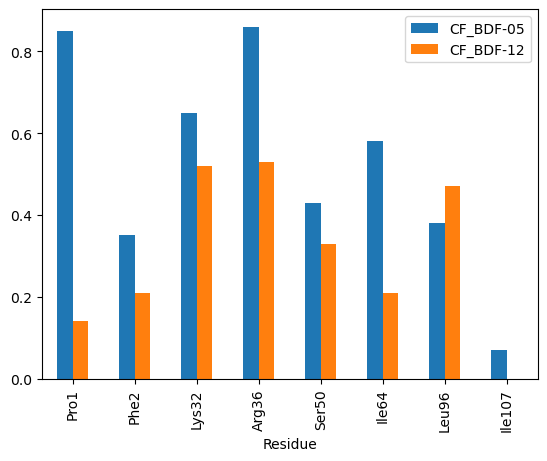

In [166]:
df_merged.plot(x="Residue",kind="bar")